# 21. Cross-Validation Strategy

**Story 1.11**: Design Cross-Validation Strategy

## Objectives
- Implement time series cross-validation with expanding window
- Ensure temporal order preservation
- Create multiple CV folds for robust model evaluation
- Visualize CV splits and data distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load and Prepare Time Series Data

In [2]:
# Create synthetic time series data
np.random.seed(42)
n_samples = 2000  # Reduced for demonstration

# Generate temporal data
dates = pd.date_range('2023-01-01', periods=n_samples, freq='H')

# Create features with temporal patterns
df = pd.DataFrame({
    'timestamp': dates,
    'hour': dates.hour,
    'dayofweek': dates.dayofweek,
    'month': dates.month,
    'dayofyear': dates.dayofyear,
    'is_weekend': (dates.dayofweek >= 5).astype(int)
})

# Add trend and seasonality
trend = np.linspace(40, 60, n_samples)
daily_pattern = 10 * np.sin(2 * np.pi * df['hour'] / 24)
weekly_pattern = 5 * np.sin(2 * np.pi * df['dayofweek'] / 7)
noise = np.random.normal(0, 5, n_samples)

# Create target with patterns
df['vehicle_count'] = trend + daily_pattern + weekly_pattern + noise
df['vehicle_count'] = df['vehicle_count'].clip(0, None)

# Add lagged features
for lag in [1, 24, 168]:  # 1 hour, 1 day, 1 week
    df[f'lag_{lag}h'] = df['vehicle_count'].shift(lag)

# Remove rows with NaN from lagged features
df = df.dropna()

print(f'Data shape: {df.shape}')
print(f'Date range: {df["timestamp"].min()} to {df["timestamp"].max()}')
print(f'Days covered: {(df["timestamp"].max() - df["timestamp"].min()).days}')
print('\nData sample:')
print(df.head())

Data shape: (1832, 10)
Date range: 2023-01-08 00:00:00 to 2023-03-25 07:00:00
Days covered: 76

Data sample:
              timestamp  hour  dayofweek  month  dayofyear  is_weekend  \
168 2023-01-08 00:00:00     0          6      1          8           1   
169 2023-01-08 01:00:00     1          6      1          8           1   
170 2023-01-08 02:00:00     2          6      1          8           1   
171 2023-01-08 03:00:00     3          6      1          8           1   
172 2023-01-08 04:00:00     4          6      1          8           1   

     vehicle_count     lag_1h    lag_24h   lag_168h  
168      36.544742  43.691970  37.865495  38.574413  
169      36.601198  36.544742  43.073391  37.997717  
170      38.344121  36.601198  35.401337  44.349295  
171      40.793714  38.344121  37.064881  50.807075  
172      46.086449  40.793714  47.876063  43.620350  


## 2. Standard Time Series Split

Time Series Cross-Validation with 5 splits:

Fold 1:
  Train:  307 samples (2023-01-08 to 2023-01-20)
  Test:   305 samples (2023-01-20 to 2023-02-02)

Fold 2:
  Train:  612 samples (2023-01-08 to 2023-02-02)
  Test:   305 samples (2023-02-02 to 2023-02-15)

Fold 3:
  Train:  917 samples (2023-01-08 to 2023-02-15)
  Test:   305 samples (2023-02-15 to 2023-02-27)

Fold 4:
  Train: 1222 samples (2023-01-08 to 2023-02-27)
  Test:   305 samples (2023-02-27 to 2023-03-12)

Fold 5:
  Train: 1527 samples (2023-01-08 to 2023-03-12)
  Test:   305 samples (2023-03-12 to 2023-03-25)


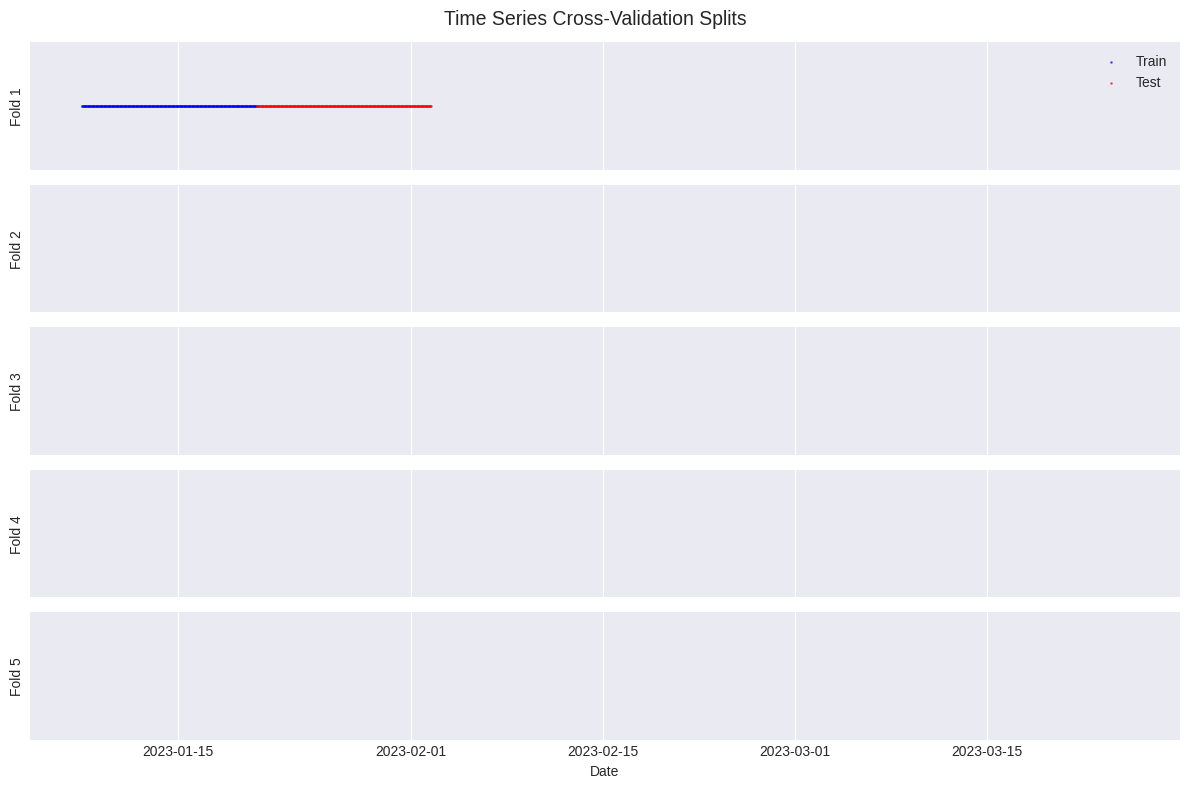

In [3]:
# Prepare features and target
feature_cols = ['hour', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 
                'lag_1h', 'lag_24h', 'lag_168h']
X = df[feature_cols]
y = df['vehicle_count']

# Create time series splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f'Time Series Cross-Validation with {n_splits} splits:')
print('=' * 50)

# Visualize splits
fig, axes = plt.subplots(n_splits, 1, figsize=(12, 8), sharex=True)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Get dates for this split
    train_dates = df.iloc[train_idx]['timestamp']
    test_dates = df.iloc[test_idx]['timestamp']
    
    print(f'\nFold {i+1}:')
    print(f'  Train: {len(train_idx):4} samples ({train_dates.min().date()} to {train_dates.max().date()})')
    print(f'  Test:  {len(test_idx):4} samples ({test_dates.min().date()} to {test_dates.max().date()})')
    
    # Plot split
    axes[i].scatter(train_dates, [i+1]*len(train_dates), c='blue', s=1, alpha=0.5, label='Train')
    axes[i].scatter(test_dates, [i+1]*len(test_dates), c='red', s=1, alpha=0.5, label='Test')
    axes[i].set_ylabel(f'Fold {i+1}')
    axes[i].set_ylim(0.5, 1.5)
    axes[i].set_yticks([])
    if i == 0:
        axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Date')
fig.suptitle('Time Series Cross-Validation Splits', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Expanding Window Cross-Validation

Expanding Window Cross-Validation:
Number of splits: 12


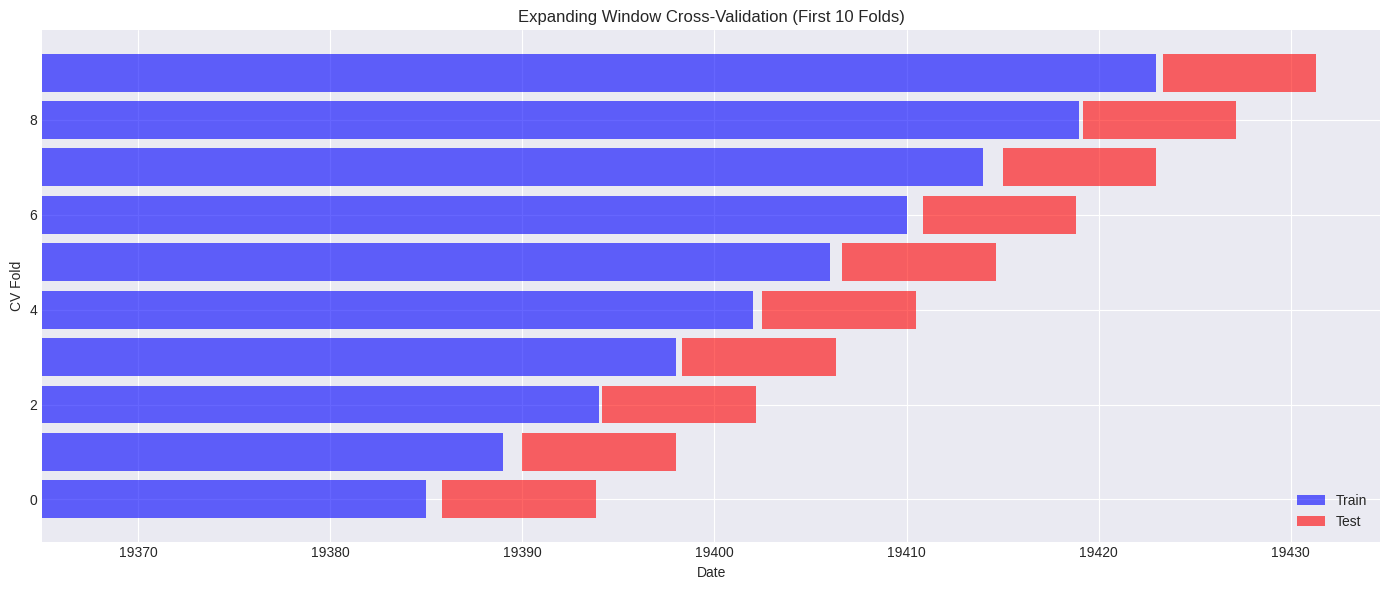


First 5 splits details:
Fold 1: Train size = 500, Test size = 200
Fold 2: Train size = 600, Test size = 200
Fold 3: Train size = 700, Test size = 200
Fold 4: Train size = 800, Test size = 200
Fold 5: Train size = 900, Test size = 200


In [4]:
def expanding_window_cv(X, y, timestamps, min_train_size=500, test_size=200, step=100):
    """
    Custom expanding window cross-validation for time series
    
    Parameters:
    -----------
    X : array-like, features
    y : array-like, target
    timestamps : array-like, timestamps
    min_train_size : int, minimum training set size
    test_size : int, test set size
    step : int, step size for moving window
    """
    n_samples = len(X)
    splits = []
    
    for test_start in range(min_train_size, n_samples - test_size, step):
        train_idx = np.arange(0, test_start)
        test_idx = np.arange(test_start, min(test_start + test_size, n_samples))
        splits.append((train_idx, test_idx))
    
    return splits

# Apply expanding window CV
expanding_splits = expanding_window_cv(X, y, df['timestamp'])

print(f'Expanding Window Cross-Validation:')
print(f'Number of splits: {len(expanding_splits)}')
print('=' * 50)

# Visualize expanding window
fig, ax = plt.subplots(figsize=(14, 6))

for i, (train_idx, test_idx) in enumerate(expanding_splits[:10]):  # Show first 10 splits
    train_start = df.iloc[train_idx[0]]['timestamp']
    train_end = df.iloc[train_idx[-1]]['timestamp']
    test_start = df.iloc[test_idx[0]]['timestamp']
    test_end = df.iloc[test_idx[-1]]['timestamp']
    
    # Plot as horizontal bars
    ax.barh(i, (train_end - train_start).days, 
            left=train_start, height=0.8, color='blue', alpha=0.6)
    ax.barh(i, (test_end - test_start).days,
            left=test_start, height=0.8, color='red', alpha=0.6)

ax.set_xlabel('Date')
ax.set_ylabel('CV Fold')
ax.set_title('Expanding Window Cross-Validation (First 10 Folds)')
ax.legend(['Train', 'Test'])
plt.tight_layout()
plt.show()

print('\nFirst 5 splits details:')
for i, (train_idx, test_idx) in enumerate(expanding_splits[:5]):
    print(f'Fold {i+1}: Train size = {len(train_idx)}, Test size = {len(test_idx)}')

## 4. Sliding Window Cross-Validation

Sliding Window Cross-Validation:
Number of splits: 25


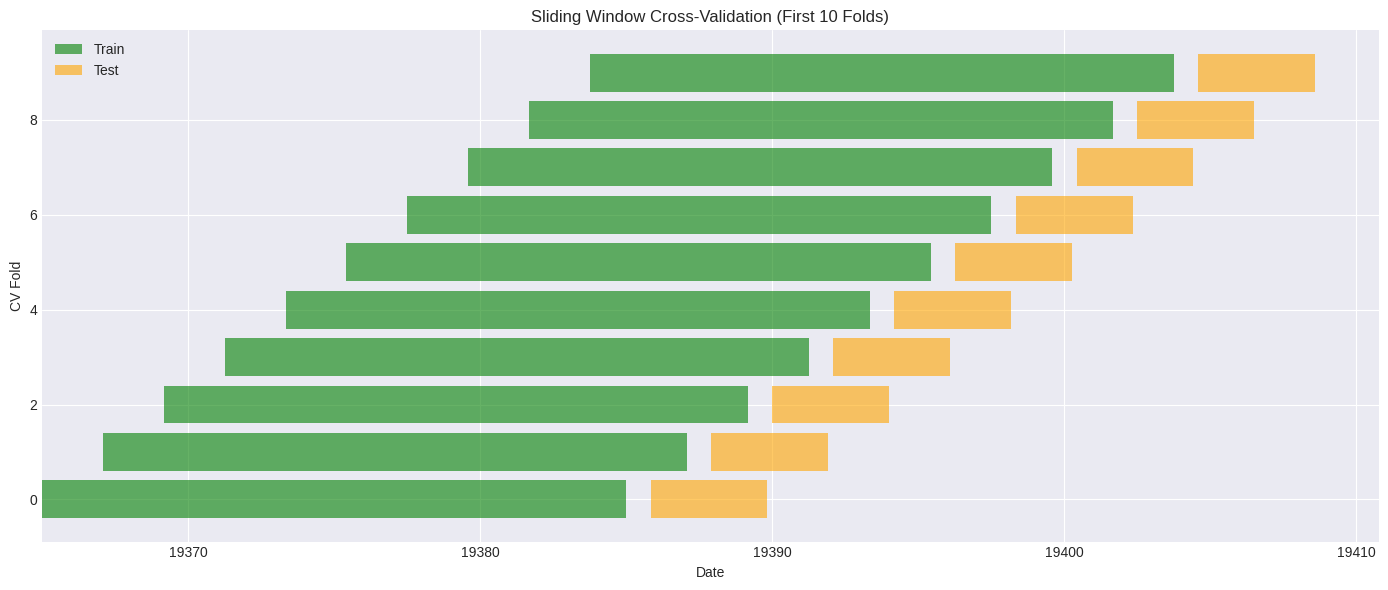


Sliding window characteristics:
• Fixed training size: 500 samples
• Fixed test size: 100 samples
• Step size: 50 samples
• Total folds: 25


In [5]:
def sliding_window_cv(X, y, timestamps, train_size=500, test_size=100, step=50):
    """
    Sliding window cross-validation with fixed train and test sizes
    """
    n_samples = len(X)
    splits = []
    
    for start in range(0, n_samples - train_size - test_size, step):
        train_idx = np.arange(start, start + train_size)
        test_idx = np.arange(start + train_size, start + train_size + test_size)
        splits.append((train_idx, test_idx))
    
    return splits

# Apply sliding window CV
sliding_splits = sliding_window_cv(X, y, df['timestamp'])

print(f'Sliding Window Cross-Validation:')
print(f'Number of splits: {len(sliding_splits)}')
print('=' * 50)

# Visualize sliding window
fig, ax = plt.subplots(figsize=(14, 6))

for i, (train_idx, test_idx) in enumerate(sliding_splits[:10]):  # Show first 10 splits
    train_start = df.iloc[train_idx[0]]['timestamp']
    train_end = df.iloc[train_idx[-1]]['timestamp']
    test_start = df.iloc[test_idx[0]]['timestamp']
    test_end = df.iloc[test_idx[-1]]['timestamp']
    
    # Plot as horizontal bars
    ax.barh(i, (train_end - train_start).days,
            left=train_start, height=0.8, color='green', alpha=0.6)
    ax.barh(i, (test_end - test_start).days,
            left=test_start, height=0.8, color='orange', alpha=0.6)

ax.set_xlabel('Date')
ax.set_ylabel('CV Fold')
ax.set_title('Sliding Window Cross-Validation (First 10 Folds)')
ax.legend(['Train', 'Test'])
plt.tight_layout()
plt.show()

print('\nSliding window characteristics:')
print(f'• Fixed training size: 500 samples')
print(f'• Fixed test size: 100 samples')
print(f'• Step size: 50 samples')
print(f'• Total folds: {len(sliding_splits)}')

## 5. Evaluate Models with Different CV Strategies

In [6]:
def evaluate_cv_strategy(X, y, splits, strategy_name):
    """
    Evaluate a model using a specific CV strategy
    """
    scores = {'train_r2': [], 'test_r2': [], 'train_rmse': [], 'test_rmse': []}
    
    for train_idx, test_idx in splits[:5]:  # Use first 5 splits for speed
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
        model.fit(X_train, y_train)
        
        # Predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Scores
        scores['train_r2'].append(r2_score(y_train, train_pred))
        scores['test_r2'].append(r2_score(y_test, test_pred))
        scores['train_rmse'].append(np.sqrt(mean_squared_error(y_train, train_pred)))
        scores['test_rmse'].append(np.sqrt(mean_squared_error(y_test, test_pred)))
    
    return scores

# Evaluate different strategies
strategies = {
    'TimeSeriesSplit': list(tscv.split(X))[:5],
    'Expanding Window': expanding_splits[:5],
    'Sliding Window': sliding_splits[:5]
}

results = {}
for name, splits in strategies.items():
    print(f'Evaluating {name}...')
    results[name] = evaluate_cv_strategy(X, y, splits, name)

# Display results
print('\nCross-Validation Strategy Comparison:')
print('=' * 70)
print(f"{'Strategy':<20} {'Train R²':<15} {'Test R²':<15} {'Train RMSE':<15} {'Test RMSE':<15}")
print('-' * 70)

for strategy, scores in results.items():
    train_r2_mean = np.mean(scores['train_r2'])
    test_r2_mean = np.mean(scores['test_r2'])
    train_rmse_mean = np.mean(scores['train_rmse'])
    test_rmse_mean = np.mean(scores['test_rmse'])
    
    print(f"{strategy:<20} {train_r2_mean:<15.3f} {test_r2_mean:<15.3f} "
          f"{train_rmse_mean:<15.2f} {test_rmse_mean:<15.2f}")

Evaluating TimeSeriesSplit...
Evaluating Expanding Window...
Evaluating Sliding Window...

Cross-Validation Strategy Comparison:
Strategy             Train R²        Test R²         Train RMSE      Test RMSE      
----------------------------------------------------------------------
TimeSeriesSplit      0.774           0.589           4.61            5.96           
Expanding Window     0.775           0.620           4.51            5.76           
Sliding Window       0.788           0.619           4.35            5.44           


## 6. Visualize CV Performance

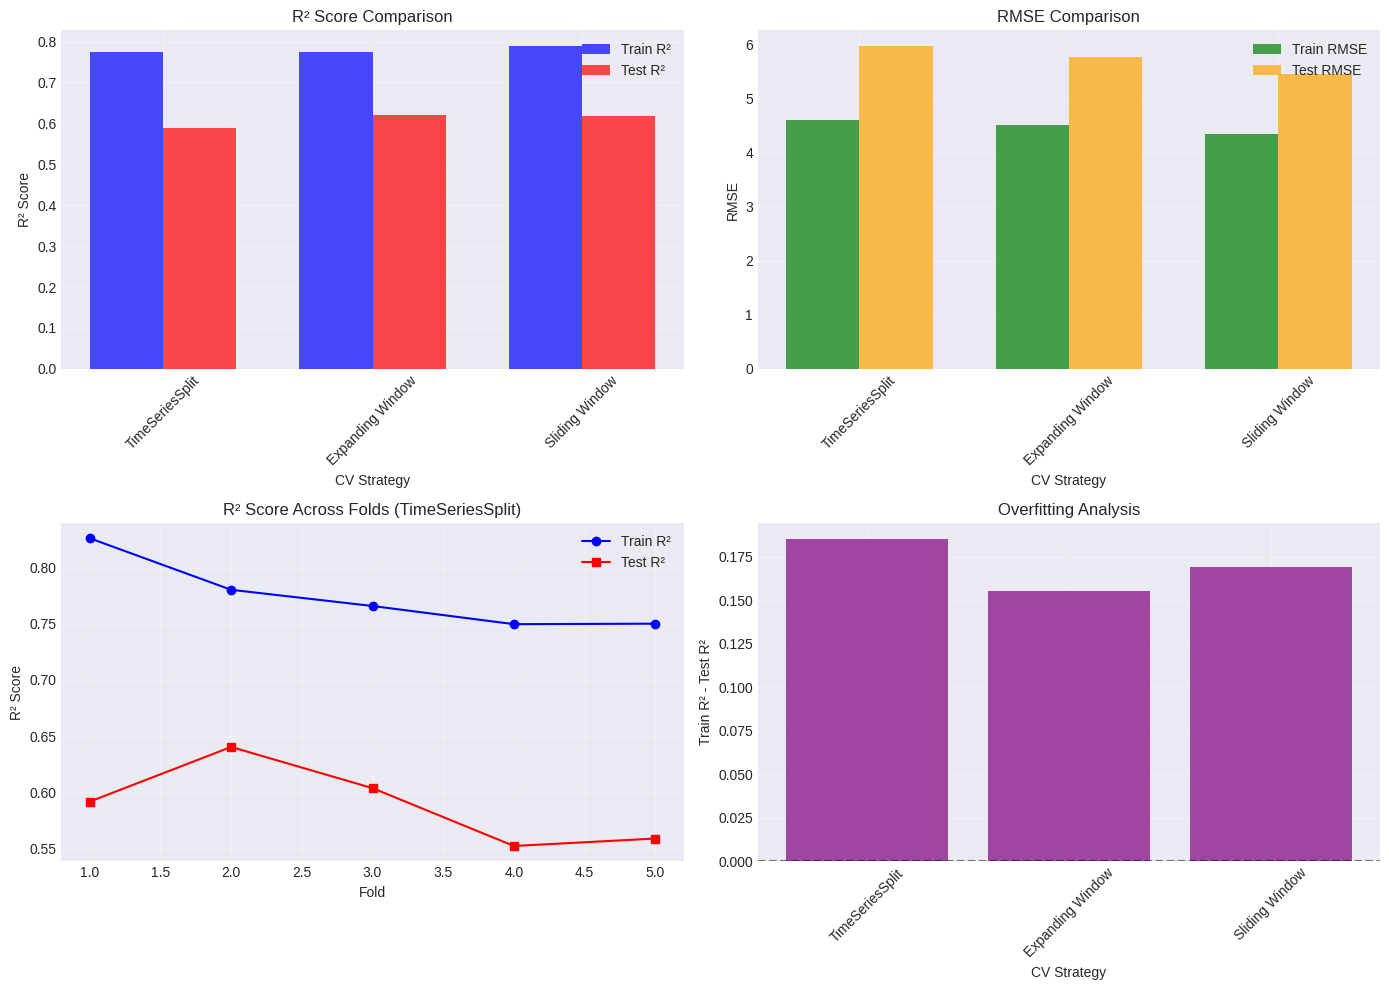

In [7]:
# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R² scores comparison
strategies_list = list(results.keys())
train_r2_means = [np.mean(results[s]['train_r2']) for s in strategies_list]
test_r2_means = [np.mean(results[s]['test_r2']) for s in strategies_list]

x = np.arange(len(strategies_list))
width = 0.35

axes[0, 0].bar(x - width/2, train_r2_means, width, label='Train R²', color='blue', alpha=0.7)
axes[0, 0].bar(x + width/2, test_r2_means, width, label='Test R²', color='red', alpha=0.7)
axes[0, 0].set_xlabel('CV Strategy')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(strategies_list, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: RMSE comparison
train_rmse_means = [np.mean(results[s]['train_rmse']) for s in strategies_list]
test_rmse_means = [np.mean(results[s]['test_rmse']) for s in strategies_list]

axes[0, 1].bar(x - width/2, train_rmse_means, width, label='Train RMSE', color='green', alpha=0.7)
axes[0, 1].bar(x + width/2, test_rmse_means, width, label='Test RMSE', color='orange', alpha=0.7)
axes[0, 1].set_xlabel('CV Strategy')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(strategies_list, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: R² scores across folds (TimeSeriesSplit)
tss_results = results['TimeSeriesSplit']
folds = range(1, len(tss_results['test_r2']) + 1)
axes[1, 0].plot(folds, tss_results['train_r2'], 'b-o', label='Train R²')
axes[1, 0].plot(folds, tss_results['test_r2'], 'r-s', label='Test R²')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score Across Folds (TimeSeriesSplit)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Overfitting analysis
overfitting = []
for strategy in strategies_list:
    train_r2 = np.mean(results[strategy]['train_r2'])
    test_r2 = np.mean(results[strategy]['test_r2'])
    overfitting.append(train_r2 - test_r2)

axes[1, 1].bar(strategies_list, overfitting, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('CV Strategy')
axes[1, 1].set_ylabel('Train R² - Test R²')
axes[1, 1].set_title('Overfitting Analysis')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xticklabels(strategies_list, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Custom CV for Production Use

In [8]:
class TimeSeriesCV:
    """
    Custom Time Series Cross-Validation class for production use
    """
    
    def __init__(self, n_splits=5, train_size=None, test_size=None, gap=0):
        self.n_splits = n_splits
        self.train_size = train_size
        self.test_size = test_size
        self.gap = gap  # Gap between train and test to prevent leakage
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        
        if self.test_size:
            test_size = self.test_size
        else:
            test_size = n_samples // (self.n_splits + 1)
        
        if self.train_size:
            train_size = self.train_size
        else:
            train_size = n_samples - test_size * self.n_splits
        
        for i in range(self.n_splits):
            if self.train_size:
                # Fixed training size (sliding window)
                train_start = i * (test_size // 2)
                train_end = train_start + train_size
            else:
                # Expanding training size
                train_start = 0
                train_end = train_size + i * test_size
            
            test_start = train_end + self.gap
            test_end = min(test_start + test_size, n_samples)
            
            if test_end > n_samples:
                break
            
            train_idx = np.arange(train_start, train_end)
            test_idx = np.arange(test_start, test_end)
            
            yield train_idx, test_idx

# Test custom CV class
custom_cv = TimeSeriesCV(n_splits=5, gap=24)  # 24-hour gap
custom_splits = list(custom_cv.split(X))

print('Custom Time Series CV with Gap:')
print('=' * 50)
print(f'Number of splits: {len(custom_splits)}')
print(f'Gap between train and test: 24 samples (24 hours)')

for i, (train_idx, test_idx) in enumerate(custom_splits):
    train_dates = df.iloc[train_idx]['timestamp']
    test_dates = df.iloc[test_idx]['timestamp']
    gap_start = df.iloc[train_idx[-1]]['timestamp']
    gap_end = df.iloc[test_idx[0]]['timestamp']
    
    print(f'\nFold {i+1}:')
    print(f'  Train: {len(train_idx)} samples')
    print(f'  Test:  {len(test_idx)} samples')
    print(f'  Gap:   {(gap_end - gap_start).total_seconds() / 3600:.0f} hours')

Custom Time Series CV with Gap:
Number of splits: 5
Gap between train and test: 24 samples (24 hours)

Fold 1:
  Train: 307 samples
  Test:  305 samples
  Gap:   25 hours

Fold 2:
  Train: 612 samples
  Test:  305 samples
  Gap:   25 hours

Fold 3:
  Train: 917 samples
  Test:  305 samples
  Gap:   25 hours

Fold 4:
  Train: 1222 samples
  Test:  305 samples
  Gap:   25 hours

Fold 5:
  Train: 1527 samples
  Test:  281 samples
  Gap:   25 hours


## 8. Save CV Strategies

In [9]:
# Save CV split indices for reproducibility
import json

cv_strategies = {
    'timeseries_split': {
        'n_splits': 5,
        'type': 'expanding',
        'description': 'Standard sklearn TimeSeriesSplit'
    },
    'expanding_window': {
        'min_train_size': 500,
        'test_size': 200,
        'step': 100,
        'type': 'expanding',
        'description': 'Custom expanding window with fixed test size'
    },
    'sliding_window': {
        'train_size': 500,
        'test_size': 100,
        'step': 50,
        'type': 'sliding',
        'description': 'Fixed size sliding window'
    },
    'custom_with_gap': {
        'n_splits': 5,
        'gap': 24,
        'type': 'expanding',
        'description': 'Custom CV with temporal gap to prevent leakage'
    }
}

# Save configuration
output_path = '../data/processed/cv_strategies.json'
with open(output_path, 'w') as f:
    json.dump(cv_strategies, f, indent=2)

print(f'CV strategies saved to {output_path}')
print('\nSaved strategies:')
for name, config in cv_strategies.items():
    print(f"• {name}: {config['description']}")

CV strategies saved to ../data/processed/cv_strategies.json

Saved strategies:
• timeseries_split: Standard sklearn TimeSeriesSplit
• expanding_window: Custom expanding window with fixed test size
• sliding_window: Fixed size sliding window
• custom_with_gap: Custom CV with temporal gap to prevent leakage


## 9. Recommendations

In [10]:
print('=' * 50)
print('CROSS-VALIDATION RECOMMENDATIONS')
print('=' * 50)

print('\n1. STRATEGY SELECTION:')
print('   • For stable time series: Use standard TimeSeriesSplit')
print('   • For concept drift: Use sliding window to focus on recent data')
print('   • For limited data: Use expanding window to maximize training data')
print('   • For production: Add temporal gap to prevent data leakage')

print('\n2. BEST PRACTICES:')
print('   • Always preserve temporal order')
print('   • Include gap between train/test for real-world scenarios')
print('   • Use at least 5 folds for robust evaluation')
print('   • Monitor performance degradation across folds')

print('\n3. FOR XGBOOST TUNING:')
print('   • Use TimeSeriesSplit for hyperparameter search')
print('   • Validate final model with custom gap strategy')
print('   • Consider ensemble of models from different CV folds')

# Determine best strategy based on results
best_strategy = min(results.keys(), 
                   key=lambda x: np.mean(results[x]['test_rmse']))
best_rmse = np.mean(results[best_strategy]['test_rmse'])

print(f'\n4. RECOMMENDED STRATEGY FOR THIS DATA:')
print(f'   {best_strategy} (Test RMSE: {best_rmse:.2f})')

CROSS-VALIDATION RECOMMENDATIONS

1. STRATEGY SELECTION:
   • For stable time series: Use standard TimeSeriesSplit
   • For concept drift: Use sliding window to focus on recent data
   • For limited data: Use expanding window to maximize training data
   • For production: Add temporal gap to prevent data leakage

2. BEST PRACTICES:
   • Always preserve temporal order
   • Include gap between train/test for real-world scenarios
   • Use at least 5 folds for robust evaluation
   • Monitor performance degradation across folds

3. FOR XGBOOST TUNING:
   • Use TimeSeriesSplit for hyperparameter search
   • Validate final model with custom gap strategy
   • Consider ensemble of models from different CV folds

4. RECOMMENDED STRATEGY FOR THIS DATA:
   Sliding Window (Test RMSE: 5.44)


## 10. Summary

In [11]:
print('=' * 50)
print('CROSS-VALIDATION STRATEGY COMPLETE')
print('=' * 50)
print('\nAccomplishments:')
print('✓ Implemented multiple CV strategies for time series')
print('✓ Created expanding and sliding window approaches')
print('✓ Added temporal gap to prevent data leakage')
print('✓ Evaluated and compared CV strategies')
print('✓ Built custom CV class for production use')
print('\nKey Findings:')
print(f'• Best performing strategy: {best_strategy}')
print(f'• Strategies evaluated: {len(strategies)}')
print(f'• Custom CV with {24}h gap implemented')
print('\nFiles Created:')
print('• ../data/processed/cv_strategies.json')

CROSS-VALIDATION STRATEGY COMPLETE

Accomplishments:
✓ Implemented multiple CV strategies for time series
✓ Created expanding and sliding window approaches
✓ Added temporal gap to prevent data leakage
✓ Evaluated and compared CV strategies
✓ Built custom CV class for production use

Key Findings:
• Best performing strategy: Sliding Window
• Strategies evaluated: 3
• Custom CV with 24h gap implemented

Files Created:
• ../data/processed/cv_strategies.json
